# BDSI Data Mining Group
# Day 3  - Example Modeling - 6/21/22

In [ ]:
library(tidyr)
library(dplyr)
library(stringr)
library(ggplot2)
library(repr)
library(maps)
library(randomForest)

In [309]:
load("../temp/overdoseDatFull.Rdata")

In [310]:
head(dat)

,stateName,stateFIPS,year,mort,pop,pctUrban_2010,vetPop_2020,mdcrEnr_2019,mdcaidElig_2012,medIncome_2019,pctPovty_2019,snap_2018,pctNoIns_2019,unplmtRate_2020,popDens_2010,stateAbr,opioid_disp,rate
,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,Alabama,1,1999,153,4430141,59.04794,16362.97,45272.82,48202.43,52616.92,15.87857,33627.1,14.85452,5.975073,52131.71,NA,NA,3.453615
2,Alabama,1,2000,177,4447100,59.04794,16362.97,45272.82,48202.43,52616.92,15.87857,33627.1,14.85452,5.975073,52131.71,NA,NA,3.980122
3,Alabama,1,2001,202,4467634,59.04794,16362.97,45272.82,48202.43,52616.92,15.87857,33627.1,14.85452,5.975073,52131.71,NA,NA,4.521409
4,Alabama,1,2002,199,4480089,59.04794,16362.97,45272.82,48202.43,52616.92,15.87857,33627.1,14.85452,5.975073,52131.71,NA,NA,4.441876
5,Alabama,1,2003,176,4503491,59.04794,16362.97,45272.82,48202.43,52616.92,15.87857,33627.1,14.85452,5.975073,52131.71,NA,NA,3.908079
6,Alabama,1,2004,265,4530729,59.04794,16362.97,45272.82,48202.43,52616.92,15.87857,33627.1,14.85452,5.975073,52131.71,NA,NA,5.848948


## Modeling Mortality

### Random Forest

In [311]:
colnames(dat)

[1] "stateName"       "stateFIPS"       "year"            "mort"           
 [5] "pop"             "pctUrban_2010"   "vetPop_2020"     "mdcrEnr_2019"   
 [9] "mdcaidElig_2012" "medIncome_2019"  "pctPovty_2019"   "snap_2018"      
[13] "pctNoIns_2019"   "unplmtRate_2020" "popDens_2010"    "stateAbr"       
[17] "opioid_disp"     "rate"

In [312]:
mod.dat <- dat %>%
    filter(year > 2005) %>%
    mutate(year_cat = factor(year)) %>%
    mutate(fentynol = as.numeric(year >= 2017)) %>%
    select(-stateName, -stateFIPS, -year_cat, -mort, -stateAbr)

In [313]:
cc <- complete.cases(mod.dat)

In [314]:
mod.rf <- randomForest(rate ~ ., importance = T, data = mod.dat[cc,])

In [315]:
print(mod.rf)


Call:
 randomForest(formula = rate ~ ., data = mod.dat[cc, ], importance = T) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 4

          Mean of squared residuals: 7.96491
                    % Var explained: 89.34


In [316]:
mod.rf$importance

,%IncMSE,IncNodePurity
year,41.970966,11278.676
pop,11.993322,3231.038
pctUrban_2010,9.503058,2315.129
vetPop_2020,14.204343,2493.546
mdcrEnr_2019,16.397941,2503.927
mdcaidElig_2012,15.623395,2577.734
medIncome_2019,17.045038,2765.847
pctPovty_2019,14.620244,2264.086
snap_2018,15.671782,2147.980
pctNoIns_2019,15.871568,3061.955


In [317]:
imp = sort(mod.rf$importance[,2]/sum(mod.rf$importance[,2]),
           decreasing = T) %>%
    data.frame()

imp$var <- rownames(imp)
colnames(imp) <- c("imp", "var")
imp

,imp,var
,<dbl>,<chr>
year,0.22288219,year
unplmtRate_2020,0.10521327,unplmtRate_2020
fentynol,0.10178241,fentynol
opioid_disp,0.06689438,opioid_disp
pop,0.06384977,pop
pctNoIns_2019,0.06050846,pctNoIns_2019
medIncome_2019,0.05465695,medIncome_2019
mdcaidElig_2012,0.05093958,mdcaidElig_2012
mdcrEnr_2019,0.04948106,mdcrEnr_2019


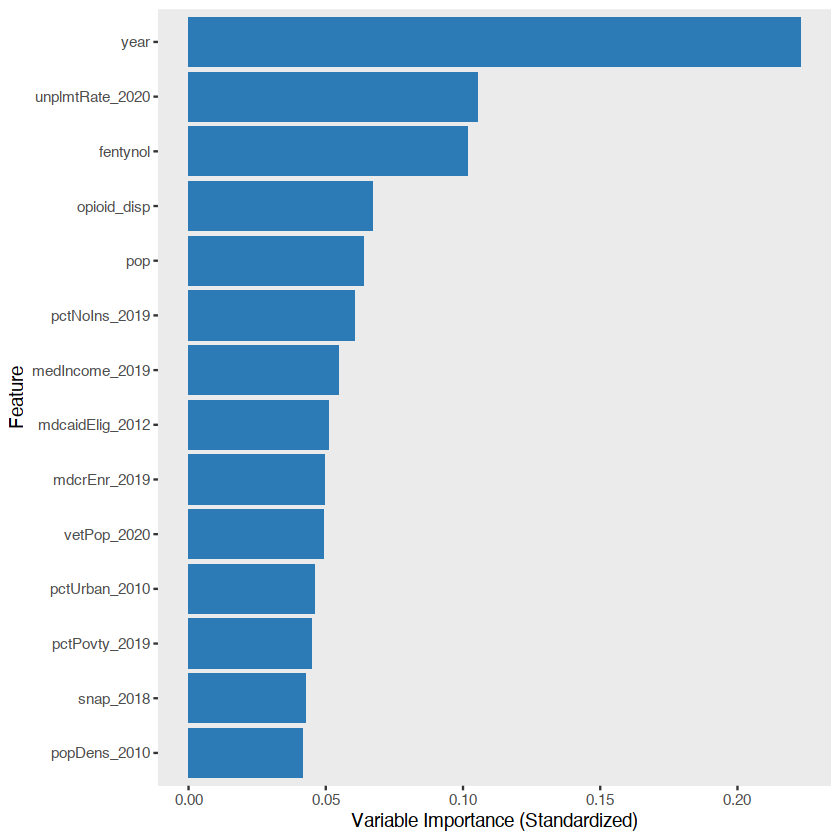

In [318]:
g <- ggplot(data=imp) + geom_col(aes(x=reorder(var,imp), y=imp), fill="#2C7BB6")
g + coord_flip() + xlab("Feature") + ylab("Variable Importance (Standardized)") +
  theme(plot.title = element_text(hjust = 0.5), panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank())

In [319]:
plot_var_funct_comb <- function(mod.obj, mod.var.names, plot.var, label, dat){
  
  #start the fake dataset to make predictions on a grid
  n.var <- which(names(dat) == plot.var)
  
  
  if(is.numeric(unlist(dat[,n.var]))){
    fake.dat <- data.frame(var = seq(min(dat[,n.var]), max(dat[,n.var]), length.out = 1000))
  }else{
    fake.dat <- data.frame(var = factor(levels(as.factor(unlist(dat[,n.var])))))
  }
  #add the median value for all other variables
  dat.vars = setdiff(mod.var.names, plot.var)
  
  for (var.name in dat.vars) {
    #get variable location
    n.var2 <- which(names(dat) == var.name)
    
    #if the variable is numeric, use the median
    if(is.numeric(unlist(dat[,n.var2]))){
      fake.dat <- fake.dat %>% 
      mutate(!!var.name := median(unlist(dat[,n.var2]), na.rm = T))
    }else{ 
    #if the variable is categorical, use the most occurring value
    fake.dat <- fake.dat %>% 
      mutate(!!var.name := factor(names(which(table(dat[,n.var2]) == max(table(dat[,n.var2]))))[1]))
    }
  }
  
  #fix the variable name for prediction
  colnames(fake.dat)[1] <- plot.var
  
  #predictions based on median values and 
  fake.dat$pred <- predict(mod.obj, type = "response", newdata = fake.dat)
  
  #fix the variable name for plotting
  colnames(fake.dat)[1] <- "var"
  
  #generate other plotting data with actual data values of variable and the predictions
  plot.dat <- data.frame(var = dat[,n.var], pred = predict(mod.obj, type = "response"))
  colnames(plot.dat)[1] <- "var"

  #plot
if(!is.numeric(unlist(dat[,n.var]))){
  g <- ggplot() +
    geom_boxplot(data = plot.dat,  aes(x = var, y = pred, group = var)) +
    geom_point(data = fake.dat, aes(x = var, y = pred) ,color = "blue", size = 1) +
    xlab(label) + ylab("Prediction") + 
    theme(plot.title = element_text(hjust = 0.5), 
            panel.border = element_blank(),
            panel.grid.minor = element_blank(),
           axis.text.x = element_text(angle=45, hjust = 1)
    )
    }else{
    g <- ggplot() +
    geom_point(data = plot.dat,  aes(x = var, y = pred)) +
    geom_point(data = fake.dat, aes(x = var, y = pred) ,color = "blue", size = 1) +
    xlab(label) + ylab("Prediction") + 
    theme(plot.title = element_text(hjust = 0.5), 
            panel.border = element_blank(),
            panel.grid.minor = element_blank(),
           axis.text.x = element_text(angle=45, hjust = 1))
    }
          
  g
  return(g)
  
}

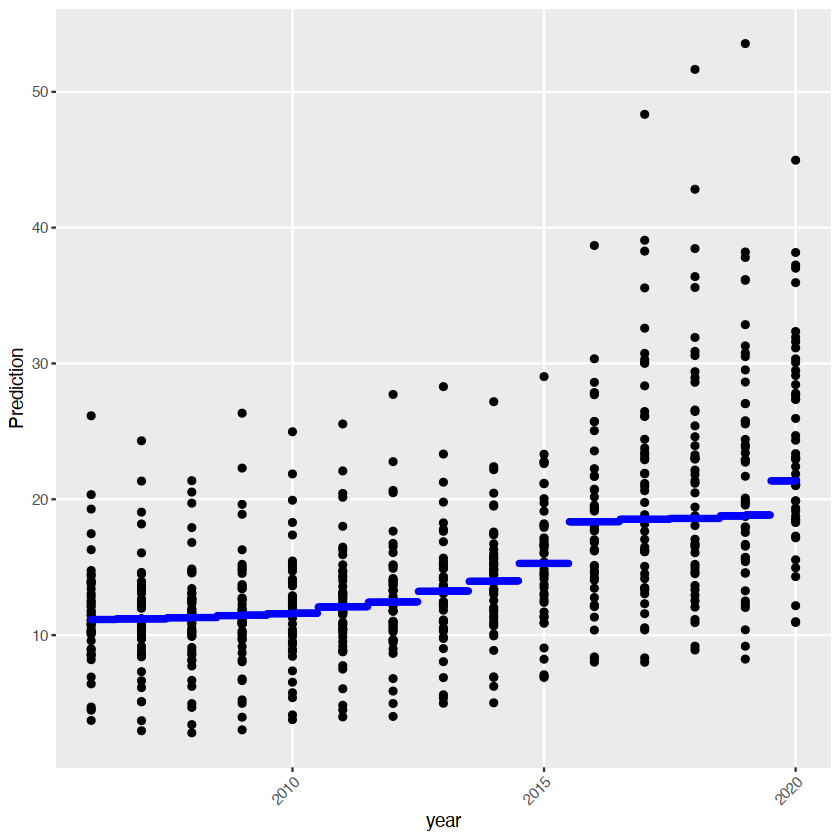

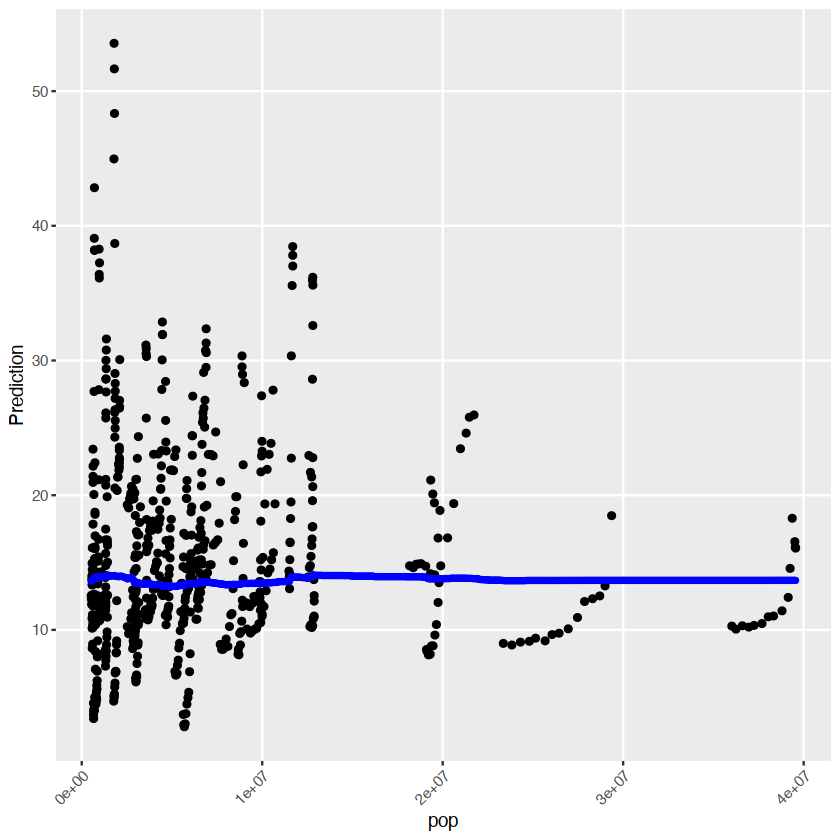

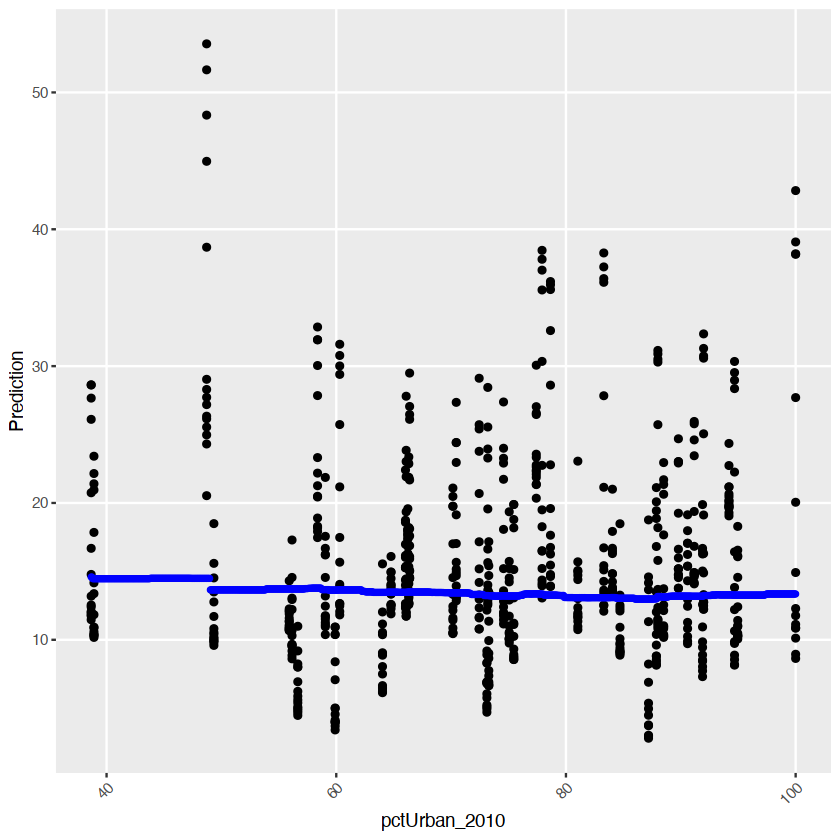

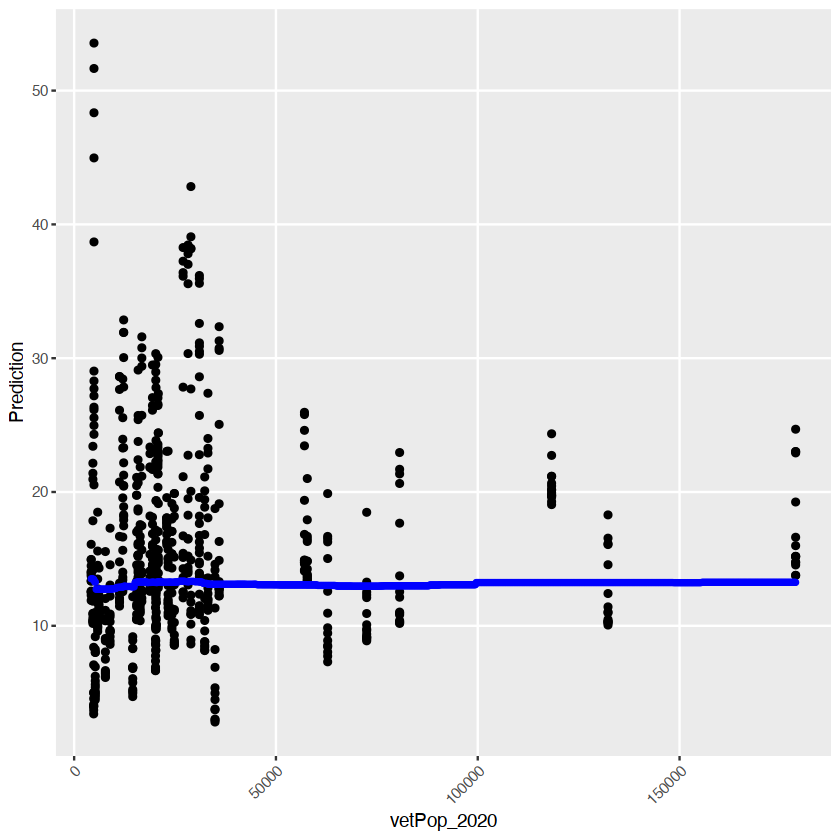

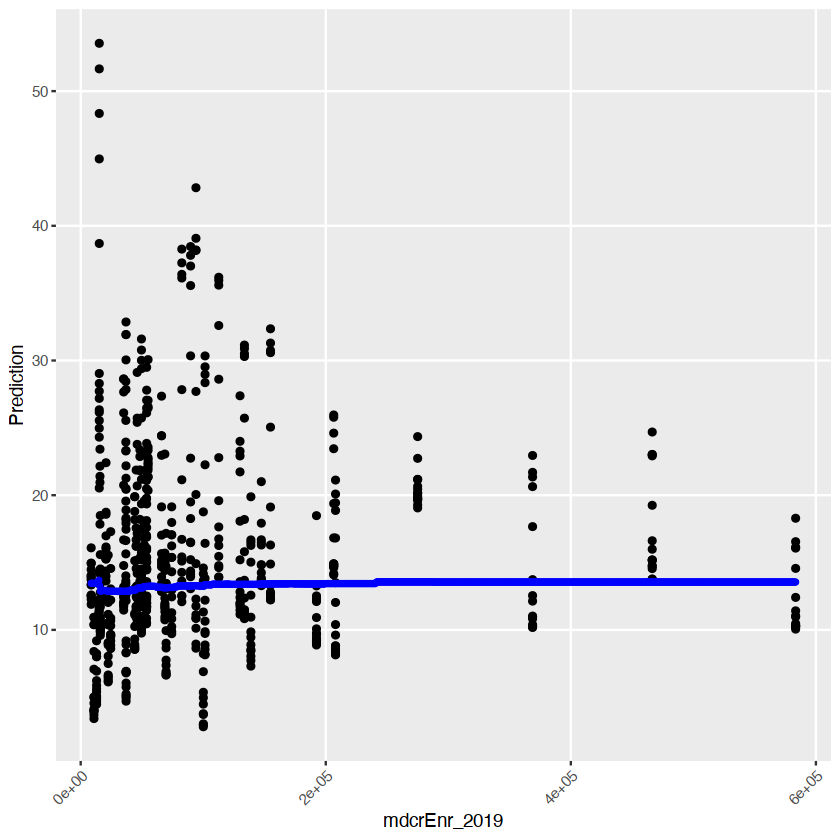

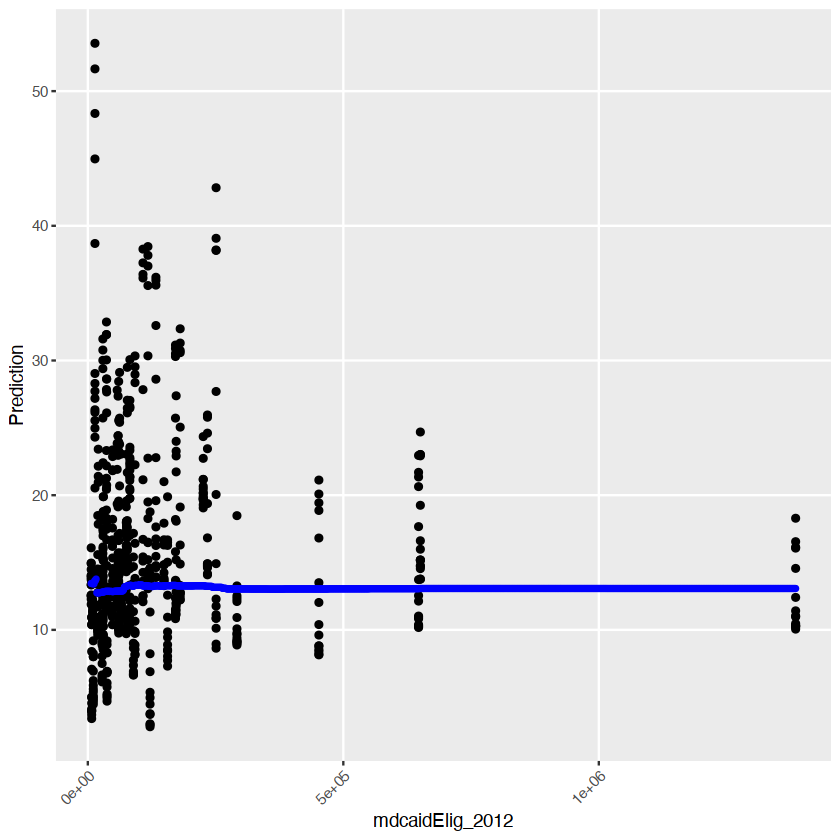

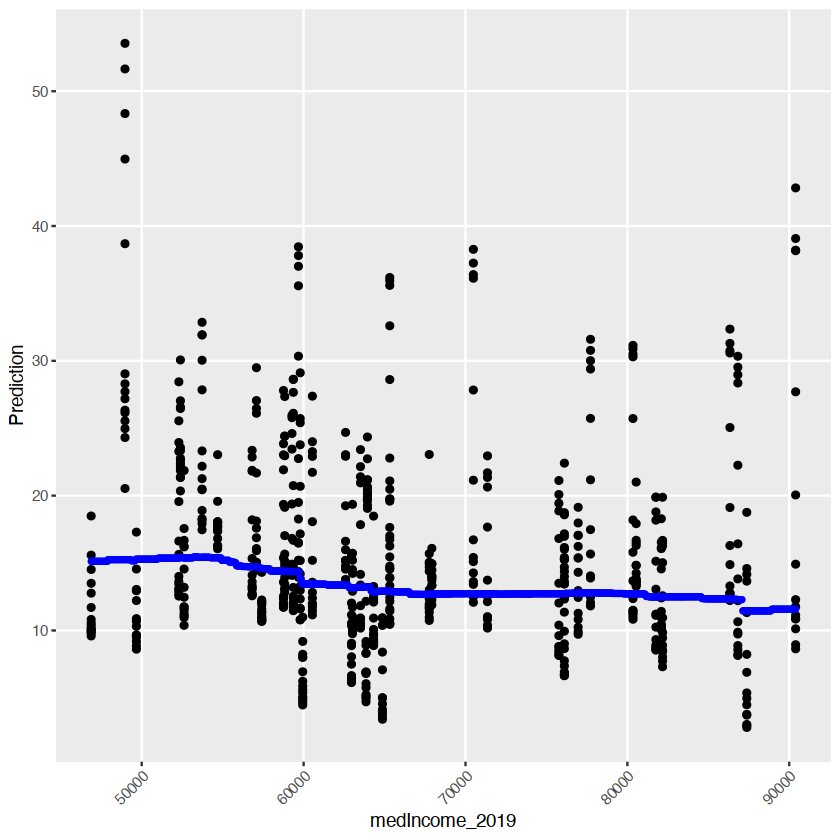

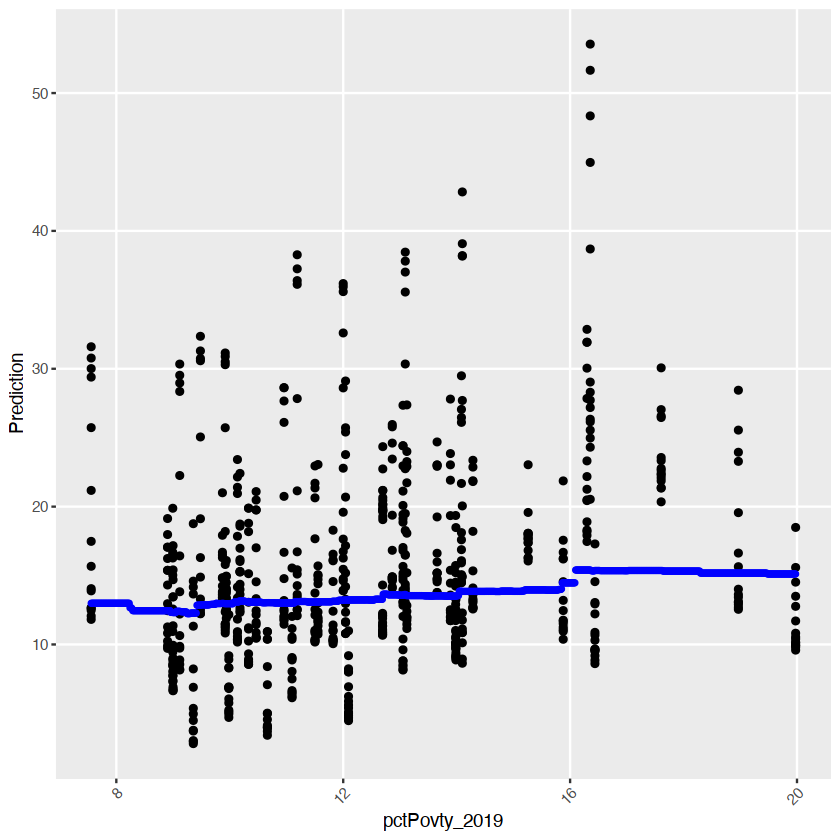

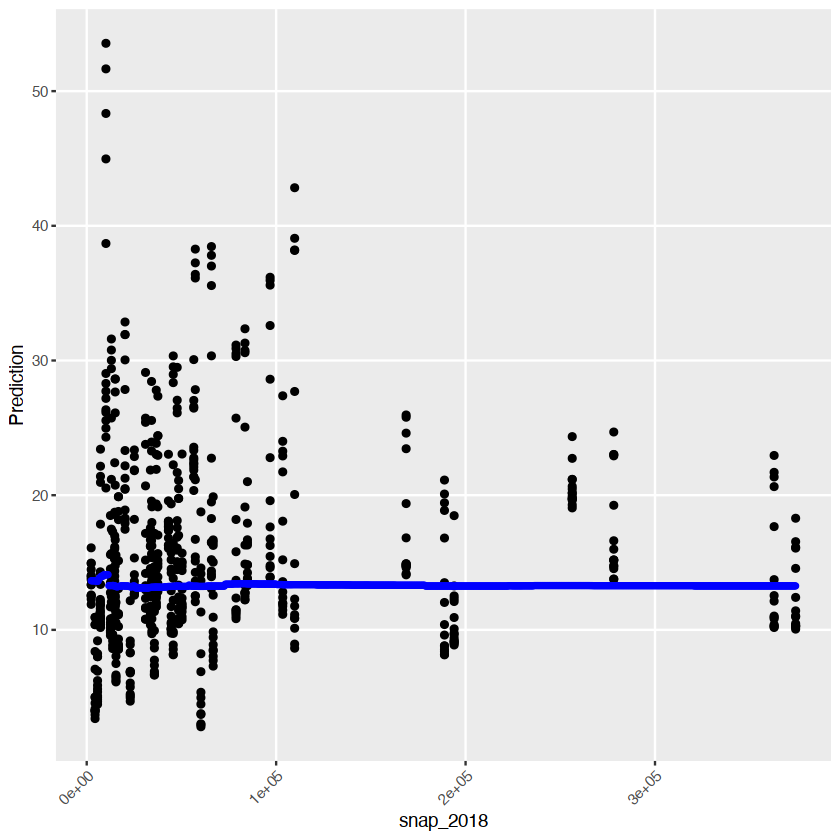

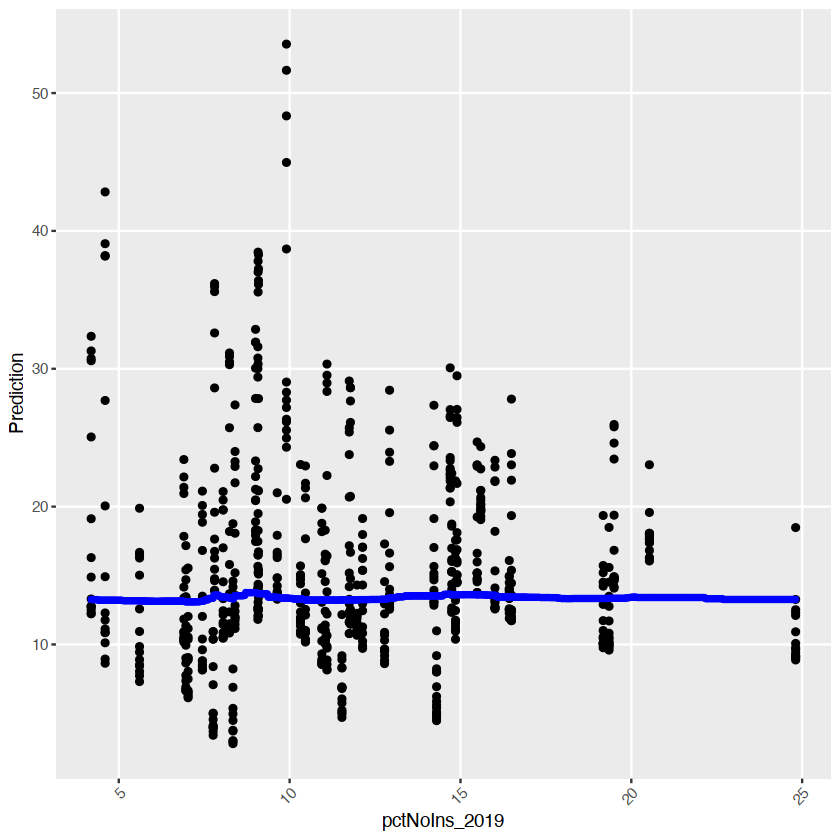

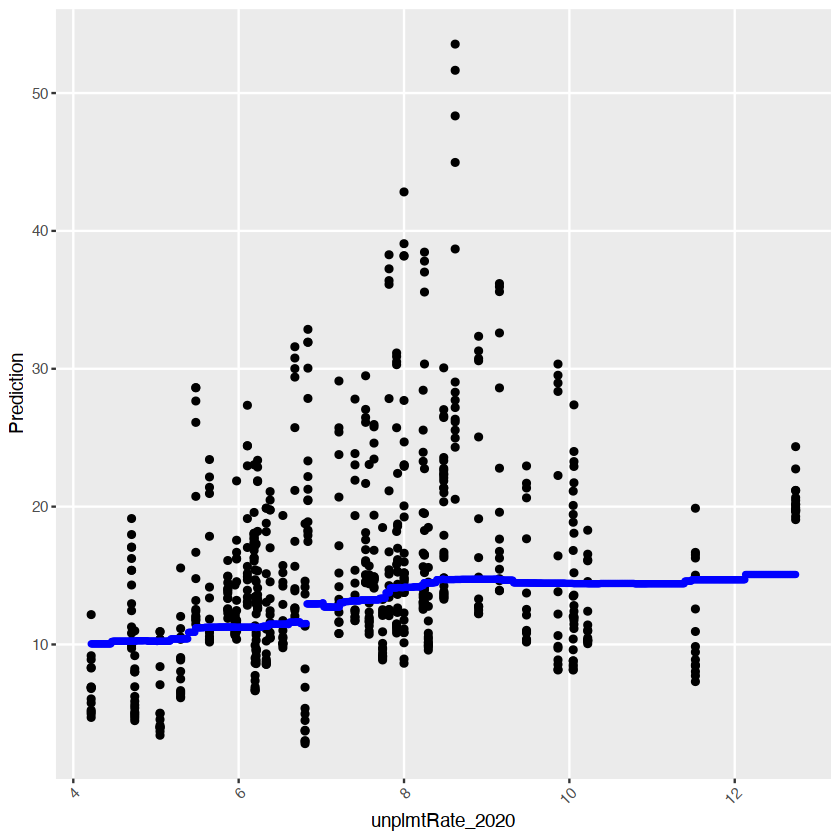

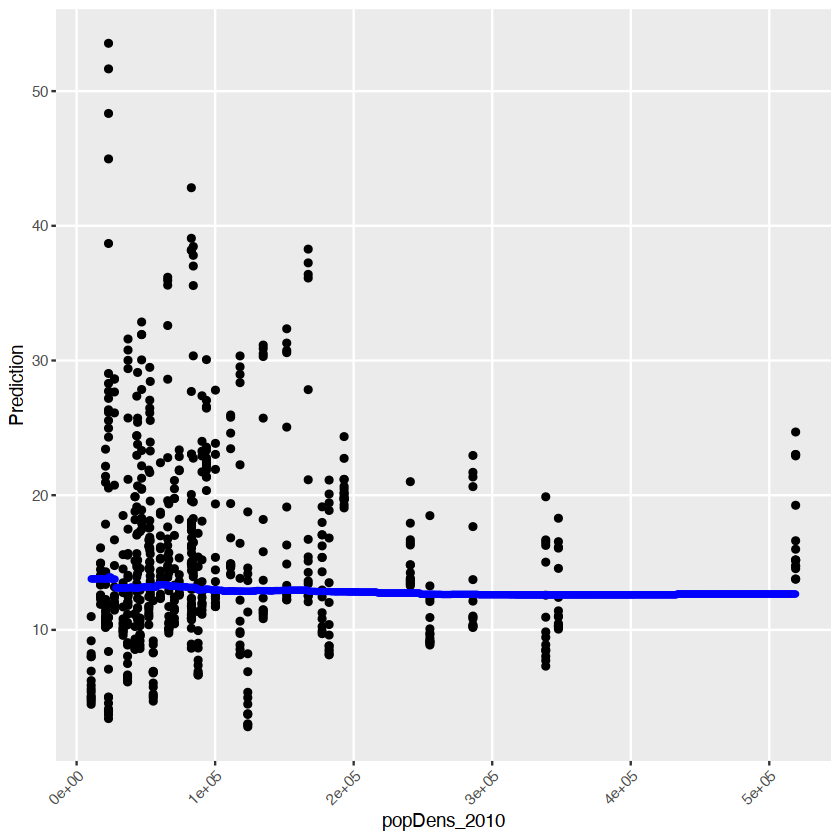

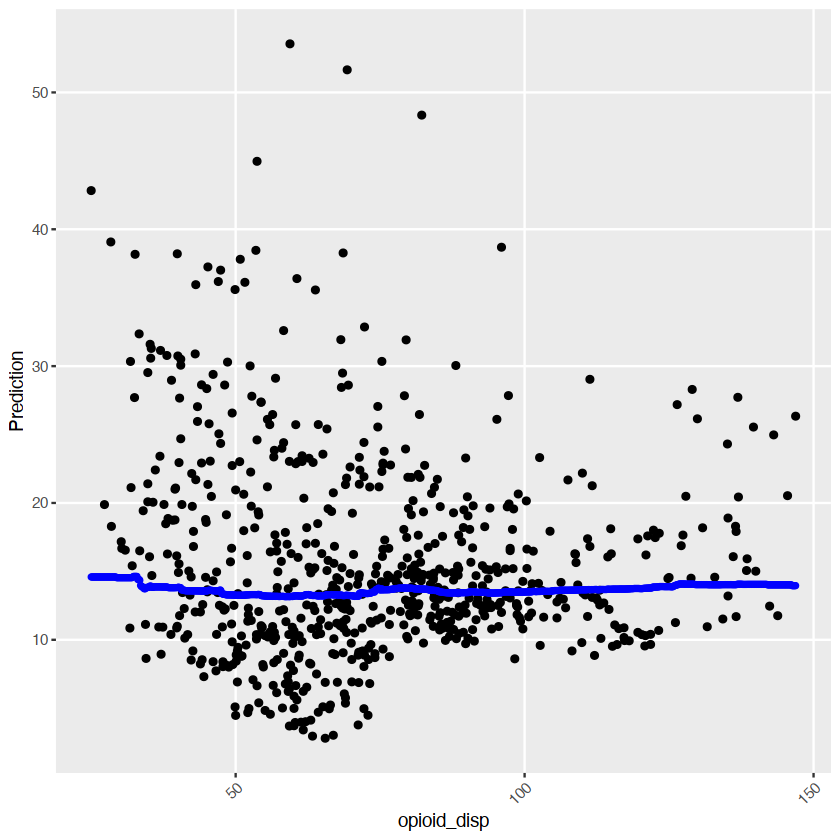

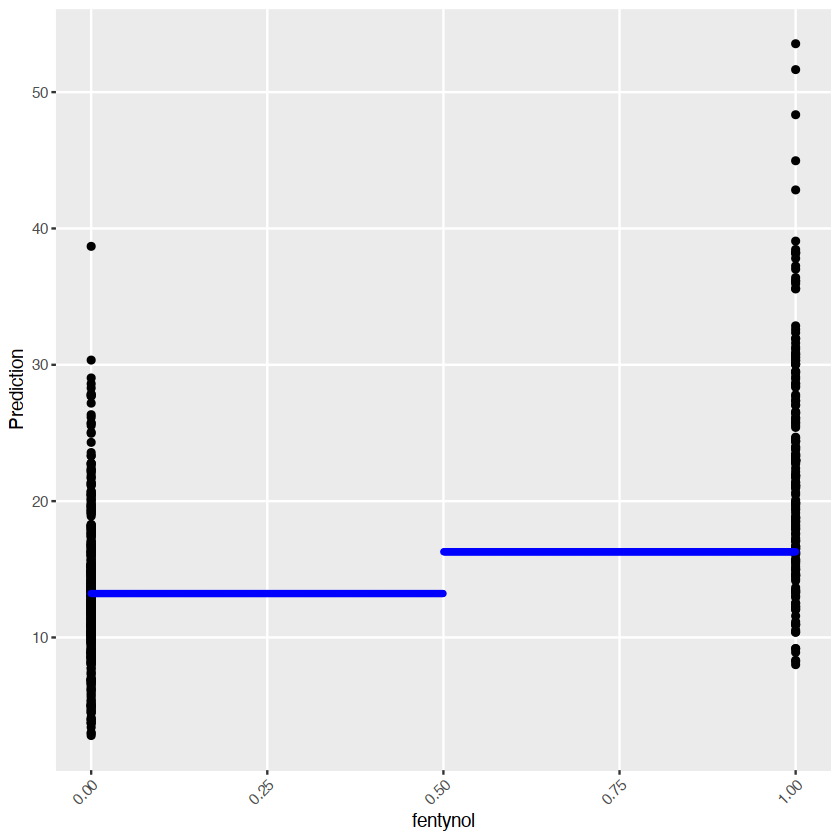

In [320]:
var.names <- rownames(mod.rf$importance)

for(var in var.names){
    p <- plot_var_funct_comb(mod.rf, var.names, var, var, mod.dat[cc,])
    print(p)
}

## GLM

In [321]:
mod.dat2 <- dat %>%
    filter(year > 2005) %>%
    mutate(year_cat = factor(year)) %>%
    mutate(fentynol = as.numeric(year >= 2017)) %>%
    mutate(across(pctUrban_2010:popDens_2010, scale))

In [322]:
mod.simple <- glm(mort ~ year_cat + opioid_disp + opioid_disp*year_cat + offset(log(pop)), 
                  family = "poisson", data = mod.dat2)

In [323]:
summary(mod.simple)


Call:
glm(formula = mort ~ year_cat + opioid_disp + opioid_disp * year_cat + 
    offset(log(pop)), family = "poisson", data = mod.dat2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-43.521   -6.279   -0.502    4.369   45.867  

Coefficients:
                           Estimate Std. Error  z value Pr(>|z|)    
(Intercept)              -9.640e+00  2.114e-02 -456.017  < 2e-16 ***
year_cat2007             -2.553e-02  2.968e-02   -0.860  0.38971    
year_cat2008             -2.099e-02  2.931e-02   -0.716  0.47395    
year_cat2009              5.432e-03  2.903e-02    0.187  0.85158    
year_cat2010             -1.161e-01  2.887e-02   -4.022 5.78e-05 ***
year_cat2011              5.273e-02  2.839e-02    1.858  0.06322 .  
year_cat2012              1.485e-01  2.834e-02    5.241 1.60e-07 ***
year_cat2013              2.721e-01  2.789e-02    9.755  < 2e-16 ***
year_cat2014              2.476e-01  2.759e-02    8.975  < 2e-16 ***
year_cat2015              3.520e-01  2.703e

In [324]:
mod.full <- glm(mort ~ year_cat + opioid_disp + opioid_disp*year_cat + 
                pctUrban_2010 + vetPop_2020 + mdcrEnr_2019 + mdcaidElig_2012 +
                medIncome_2019 + pctPovty_2019 + pctNoIns_2019 +
                unplmtRate_2020 + popDens_2010 +
                offset(log(pop)), 
                family = "poisson", data = mod.dat2)

In [325]:
summary(mod.full)


Call:
glm(formula = mort ~ year_cat + opioid_disp + opioid_disp * year_cat + 
    pctUrban_2010 + vetPop_2020 + mdcrEnr_2019 + mdcaidElig_2012 + 
    medIncome_2019 + pctPovty_2019 + pctNoIns_2019 + unplmtRate_2020 + 
    popDens_2010 + offset(log(pop)), family = "poisson", data = mod.dat2)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-25.088   -5.797   -0.274    4.615   31.660  

Coefficients:
                           Estimate Std. Error  z value Pr(>|z|)    
(Intercept)              -9.578e+00  2.282e-02 -419.650  < 2e-16 ***
year_cat2007             -3.008e-02  3.026e-02   -0.994  0.32030    
year_cat2008             -3.945e-03  2.990e-02   -0.132  0.89502    
year_cat2009              1.683e-02  2.967e-02    0.567  0.57043    
year_cat2010             -8.874e-02  2.949e-02   -3.009  0.00262 ** 
year_cat2011              8.331e-02  2.901e-02    2.872  0.00408 ** 
year_cat2012              1.499e-01  2.898e-02    5.171 2.33e-07 ***
year_cat2013              

In [326]:
library(lme4)

In [327]:
lmer.full <- glmer(mort ~ year_cat + opioid_disp + opioid_disp*year_cat + 
                pctUrban_2010 + vetPop_2020 + mdcrEnr_2019 + mdcaidElig_2012 +
                medIncome_2019 + pctPovty_2019 + pctNoIns_2019 +
                unplmtRate_2020 + popDens_2010 +
                offset(log(pop)) + (1|stateAbr), 
                family = "poisson", data = mod.dat2)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0476283 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?;Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”


In [328]:
summary(lmer.full)


Correlation matrix not shown by default, as p = 39 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: 
mort ~ year_cat + opioid_disp + opioid_disp * year_cat + pctUrban_2010 +  
    vetPop_2020 + mdcrEnr_2019 + mdcaidElig_2012 + medIncome_2019 +  
    pctPovty_2019 + pctNoIns_2019 + unplmtRate_2020 + popDens_2010 +  
    offset(log(pop)) + (1 | stateAbr)
   Data: mod.dat2

     AIC      BIC   logLik deviance df.resid 
 23990.7  24173.0 -11955.3  23910.7      665 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-24.7083  -2.7294   0.0232   2.7192  19.2613 

Random effects:
 Groups   Name        Variance Std.Dev.
 stateAbr (Intercept) 0.1072   0.3275  
Number of obs: 705, groups:  stateAbr, 47

Fixed effects:
                           Estimate Std. Error  z value Pr(>|z|)    
(Intercept)              -9.1352890  0.0576255 -158.529  < 2e-16 ***
year_cat2007             -0.0240279  0.0301107   -0.798 0.424878    
year_cat2008             -0.013

### Visualize coefficients

In [329]:
coef.df <- data.frame(summary(lmer.full)$coefficients)
coef.df$var = row.names(coef.df)
colnames(coef.df) <- c("est", "se", "t", "p","var")
coef.df <- coef.df %>%
  mutate(sig = ifelse(p < .05, "Yes", "No"),
         coef.exp = exp(est))

Look at the year and opioid dispersion interaction.

In [330]:
coef.base <- coef.df$est[coef.df$var == "opioid_disp"]
disp.coef <- coef.df %>%
    filter(str_detect(var, "opioid")) %>%
    mutate(year = case_when(!str_detect(var, "\\d{4}")~ "2006",
                            TRUE ~ str_extract(var, "\\d{4}")),
          int.est = case_when(year == "2006" ~ est,
                              TRUE ~ est+coef.base),
          int.est.exp = exp(int.est),
          sig = case_when(year == "2006" ~ "NA",
                         TRUE ~ sig))

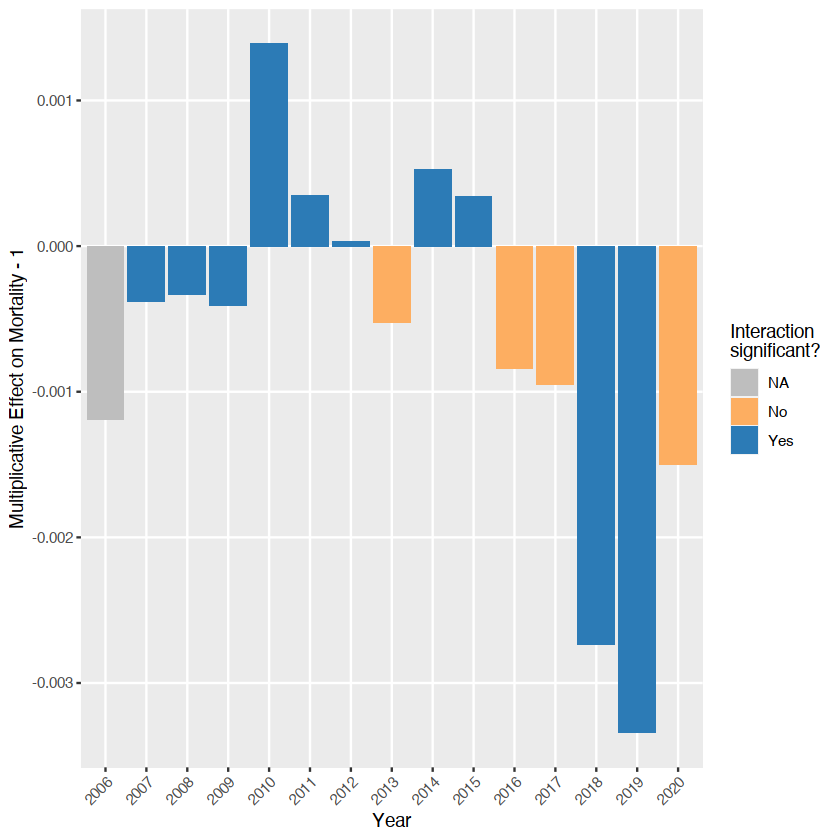

In [331]:
g <- ggplot(data=disp.coef, aes(x=factor(year))) + 
    geom_bar(aes(y=int.est.exp-1, fill = sig), stat ="identity", position="dodge")
g1 <- g + xlab("Year") + ylab("Multiplicative Effect on Mortality - 1") +
  theme(plot.title = element_text(hjust = 0.5), panel.border = element_blank(),
        #panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.text.x = element_text(angle=45, hjust = 1)) +
  scale_fill_manual(name = "Interaction\nsignificant?", values = c("grey","#fdae61", "#2C7BB6"))
g1

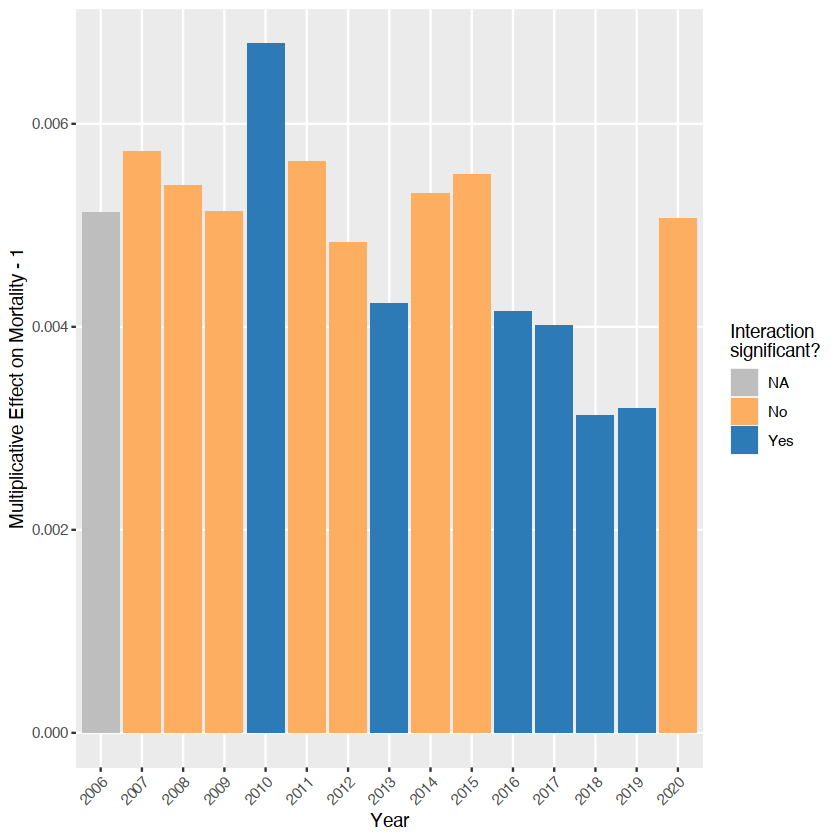

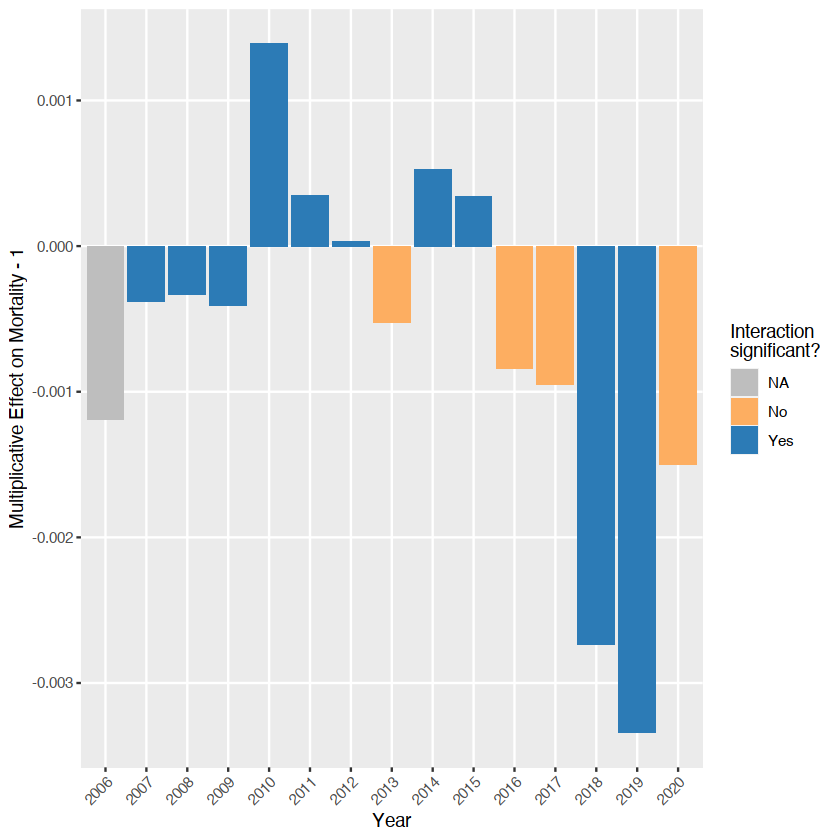

In [332]:
coef.df <- data.frame(summary(mod.full)$coefficients)
coef.df$var = row.names(coef.df)
colnames(coef.df) <- c("est", "se", "t", "p","var")
coef.df <- coef.df %>%
  mutate(sig = ifelse(p < .05, "Yes", "No"),
         coef.exp = exp(est))
coef.base <- coef.df$est[coef.df$var == "opioid_disp"]
disp.coef <- coef.df %>%
    filter(str_detect(var, "opioid")) %>%
    mutate(year = case_when(!str_detect(var, "\\d{4}")~ "2006",
                            TRUE ~ str_extract(var, "\\d{4}")),
          int.est = case_when(year == "2006" ~ est,
                              TRUE ~ est+coef.base),
          int.est.exp = exp(int.est),
          sig = case_when(year == "2006" ~ "NA",
                         TRUE ~ sig))
g2 <- ggplot(data=disp.coef, aes(x=factor(year))) + 
    geom_bar(aes(y=int.est.exp-1, fill = sig), stat ="identity", position="dodge")
g2 + xlab("Year") + ylab("Multiplicative Effect on Mortality - 1") +
  theme(plot.title = element_text(hjust = 0.5), panel.border = element_blank(),
        #panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.text.x = element_text(angle=45, hjust = 1)) +
  scale_fill_manual(name = "Interaction\nsignificant?", values = c("grey","#fdae61", "#2C7BB6"))
g1